<a href="https://colab.research.google.com/github/Anpopaicoconat/serdce/blob/main/%D0%A1%D0%B5%D1%80%D0%B4%D1%86%D0%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Новый раздел

In [ ]:
 from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Презентация
Прототип модели размещен на Google Colab лишь для наглядной демонстрации в рамках хакатона. Релизная версия может находиться на любом необходимом вам хосте.

Запуск осуществляется по нажатию кнопки в левом верхнем углу. Для просмотра кода дважды кликнете на ячейку.

In [ ]:
#@title Установка зависимостей
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.preprocessing
import numpy as np
import tensorflow as tf
import keras
import ipywidgets as widgets
%load_ext tensorboard
import tensorflow as tf
import datetime, os
from keras.utils.vis_utils import plot_model

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
#@title Первичный анализ данных
def zpt(x):
    if type(x) == str:
        x = x.replace(',', '.')
    return x
 
data = pd.read_csv('/content/drive/MyDrive/hakaton/Dannye.csv', sep='\t')
data = data.drop('Уточнение', axis=1)
 
targets = pd.read_csv('/content/drive/MyDrive/hakaton/targets.csv', sep=';')
display(targets)
print('dataset')
display(pd.concat([data, targets], axis=1))
print('description')
display(data.describe())

In [ ]:
#@title препроцессинг
def f(x):
    if x == 'да':
        return 1
    elif x == 'нет' or x == 'н/д':
        return 0
    else:
        return x
age = data['Возраст']
place = data['Место проживания 1-город 2-село']
smoking = pd.concat([pd.get_dummies(data.loc[:, 'Статус Курения']), data.loc[:, 'Сигарет в день':'Сигарет прекр лет']], axis=1)
smoking = smoking.fillna(0)
alco = pd.concat([pd.get_dummies(data.loc[:, 'Алкоголь']), data.loc[:, 'Возраст алког']], axis=1)
alco = alco.fillna(0)
obs = data.loc[:, 'ИБС: № братьев / сестер':'Q-T']
obs = obs.fillna(0)
obs = obs.applymap(f)
anomal1 = data.loc[:, 'Аномальный ритм']
anomal2 = data.loc[:, 'Другие аномалии']
anomal1 = anomal1.fillna('нет аномального ритма')
anomal2 = anomal2.fillna('нет других аномалий')
anomal1 = pd.get_dummies(anomal1)
anomal2 = pd.get_dummies(anomal2)
q13 = pd.get_dummies(data.loc[:, 'Вопрос 13'])
tipj = pd.get_dummies(data.loc[:, 'Тип жилья'])
sport = data.loc[:, '4. Спорт тяжелый/ минуты':]
data_new = pd.concat([age, place, smoking, alco, obs, q13, tipj, anomal1], axis=1)
 
data_new = data_new.astype('float32')
data_new

In [ ]:
#@title 


fig, axs = plt.subplots(2, 2)
fig.set_size_inches(18.5, 10.5, forward=True)
n_bins = len(data)
axs[0][0].pie(data['Место проживания 1-город 2-село'])
axs[0][0].set_title('Возраст')

axs[0][1].hist(data['Сигарет в день'], bins=n_bins)
axs[0][1].set_title('Сигарет в день')
axs[1][0].hist(data['Сидящий итог'], bins=n_bins)
axs[1][0].set_title('Сидящий итог')

In [ ]:
#@title Минимаксная и z-нормализация 
def minmax_scaler(x, xmin, xmax, a=0, b=1):
    return (x-xmin)/(xmax-xmin)*(b-a)
 
def z_scaler(x, xmean, xstd):
    return (x-xmean)/xstd
 
 
def get_params(data_):
    scaler_params=[]
    for col_name in data_:
        column = data_.loc[:, col_name]
        data_max = column.max()
        data_min = column.min()
        data_mean = column.mean()
        data_std = column.std()
        scaler_params.append({'max':data_max, 'min':data_min, 'mean':data_mean, 'std':data_std})
    return scaler_params
 
def normaliser(data_, scaler_params):
    data_new = data_
    for n, col_name in enumerate(data_):
        column = data_.loc[:, col_name]
        params = scaler_params[n]
        if col_name:
            column = column.map(lambda x: z_scaler(x, params['mean'], params['std']))
        else:
            column = column.map(lambda x: minmax_scaler(x, params['min'], params['max']))
            print(column)
        data_new[col_name]=column
    return data_new
 
#разделение данных
x_data = data_new
y_data1 = targets.loc[:, : 'Артериальная гипертензия']
y_data2 = targets.loc[:, 'ОНМК':'ОНМК']
#print(targets.columns)
y_data3 = targets.loc[:, 'Стенокардия, ИБС, инфаркт миокарда':'Стенокардия, ИБС, инфаркт миокарда']
y_data4 = targets.loc[:, 'Сердечная недостаточность':'Сердечная недостаточность']
y_data5 = targets.loc[:, 'Прочие заболевания сердца':'Прочие заболевания сердца']
# #нормализация
scaler_params = get_params(x_data)
print(scaler_params) 
x_data = normaliser(x_data, scaler_params)
display(x_data )
x_data = x_data.to_numpy()
onehotter = sklearn.preprocessing.OneHotEncoder(sparse=False)
y_data1 = onehotter.fit_transform(y_data1)
y_data2 = onehotter.fit_transform(y_data2)
y_data3 = onehotter.fit_transform(y_data3)
y_data4 = onehotter.fit_transform(y_data4)
y_data5 = onehotter.fit_transform(y_data5)
print('нормализованные входные данные')
display(pd.DataFrame(x_data))
print('таргеты')
display(pd.DataFrame(y_data5))
x_data.shape
y_data1.shape

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 123)]        0                                            
__________________________________________________________________________________________________
dense_15 (Dense)                (None, 256)          31744       input_4[0][0]                    
__________________________________________________________________________________________________
dropout_12 (Dropout)            (None, 256)          0           dense_15[0][0]                   
__________________________________________________________________________________________________
dense_16 (Dense)                (None, 256)          65792       dropout_12[0][0]                 
_______________________________________________________________________________________

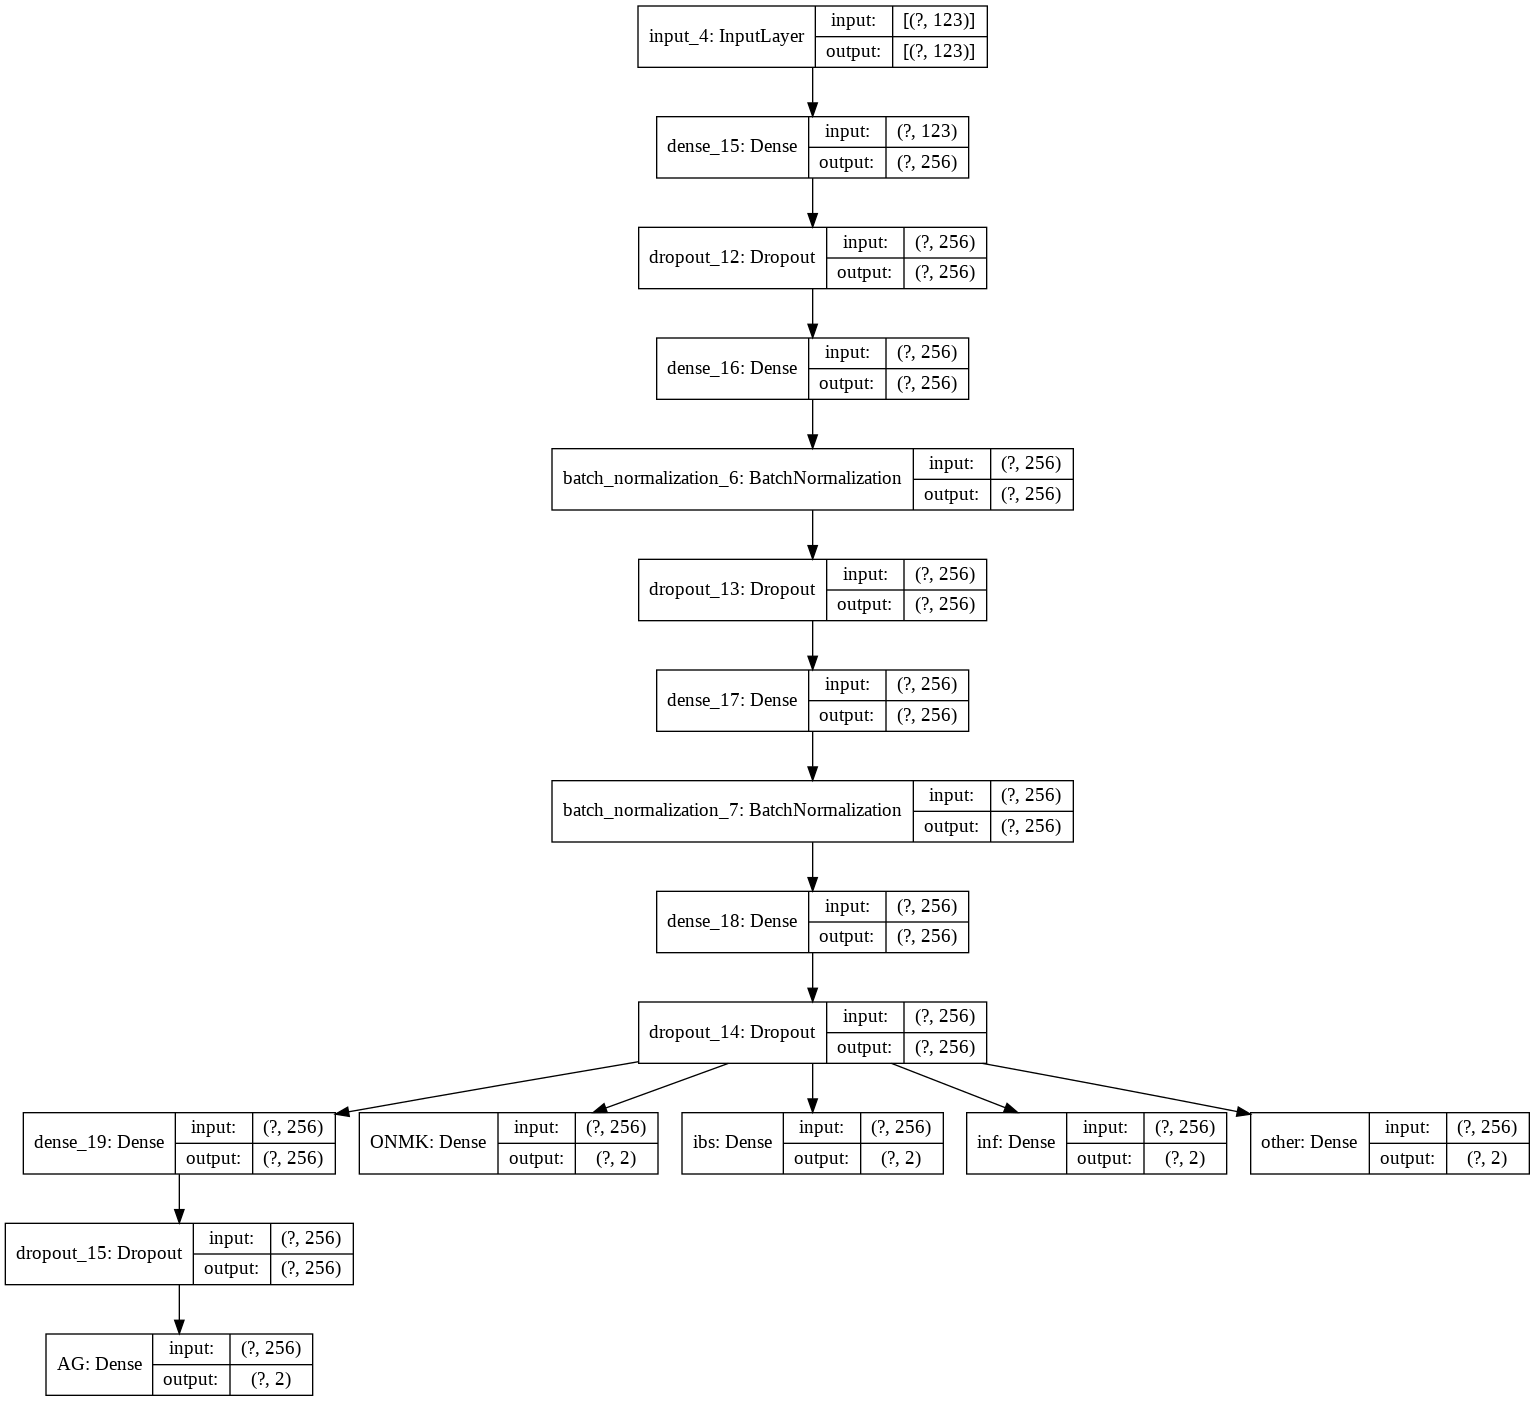

In [165]:
#@title Создание модели
INP_LEN = 123
inp = keras.Input(shape=(INP_LEN,))
 
x1 = keras.layers.Dense(256, activation='relu')(inp)
drop1 = tf.keras.layers.Dropout(0.3)(x1)
x2 = keras.layers.Dense(256, activation='relu')(drop1)
norm = tf.keras.layers.BatchNormalization()(x2)
drop2 = tf.keras.layers.Dropout(0.3)(norm)
x3 = keras.layers.Dense(256, activation='relu')(drop2)
norm1 = tf.keras.layers.BatchNormalization()(x3)
x4 = keras.layers.Dense(256, activation='relu')(norm1)
drop2 = tf.keras.layers.Dropout(0.3)(x4)
 
_out1 = keras.layers.Dense(256, activation='relu')(drop2)
drop3 = tf.keras.layers.Dropout(0.3)(_out1)
out1 = keras.layers.Dense(2, activation='softmax', name='AG')(drop3)
out2 = keras.layers.Dense(2, activation='softmax', name='ONMK')(drop2)
out3 = keras.layers.Dense(2, activation='softmax', name='ibs')(drop2)
out4 = keras.layers.Dense(2, activation='softmax', name='inf')(drop2)
out5 = keras.layers.Dense(2, activation='softmax', name='other')(drop2)
 
model = keras.models.Model(inputs=inp, outputs=[out1, out2, out3, out4, out5])
model.compile(
    optimizer='adam',
    loss = 'binary_crossentropy',
    metrics = ['acc']
    )
print(model.summary())
plot_model(model, 'model.png', show_shapes=True, show_layer_names=True)

In [166]:
#@title Обучнеие модели
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir= log_dir)
 
history = model.fit(x=x_data, y=[y_data1, y_data2, y_data3, y_data4, y_data5], epochs=20, batch_size=32, verbose=1, validation_split=0.3, shuffle=True, callbacks=[tensorboard_callback])

Epoch 1/20
35/35 [==============================] - 1s 37ms/step - loss: 2.4167 - AG_loss: 0.7942 - ONMK_loss: 0.2719 - ibs_loss: 0.5176 - inf_loss: 0.4142 - other_loss: 0.4189 - AG_acc: 0.5340 - ONMK_acc: 0.9088 - ibs_acc: 0.7961 - inf_acc: 0.8533 - other_acc: 0.8631 - val_loss: 2.4656 - val_AG_loss: 0.6962 - val_ONMK_loss: 0.3606 - val_ibs_loss: 0.4916 - val_inf_loss: 0.4618 - val_other_loss: 0.4553 - val_AG_acc: 0.5375 - val_ONMK_acc: 0.9458 - val_ibs_acc: 0.8687 - val_inf_acc: 0.8979 - val_other_acc: 0.9187
Epoch 2/20
35/35 [==============================] - 0s 8ms/step - loss: 2.0022 - AG_loss: 0.7176 - ONMK_loss: 0.1941 - ibs_loss: 0.4124 - inf_loss: 0.3435 - other_loss: 0.3346 - AG_acc: 0.5993 - ONMK_acc: 0.9615 - ibs_acc: 0.8712 - inf_acc: 0.8962 - other_acc: 0.9007 - val_loss: 2.1752 - val_AG_loss: 0.6843 - val_ONMK_loss: 0.2706 - val_ibs_loss: 0.4247 - val_inf_loss: 0.3856 - val_other_loss: 0.4101 - val_AG_acc: 0.5875 - val_ONMK_acc: 0.9458 - val_ibs_acc: 0.8667 - val_inf_acc

In [ ]:
#@title Немного более подробный лог обучения
#@markdown (требуется запустить ячейки для доступа к вкладке TensorBoard)
%tensorboard --logdir logs

In [ ]:
#@title предсказания на всей выборке
model = keras.models.load_model('/content/drive/MyDrive/hakaton/model.h5')
pred = np.array(model.predict(x_data))
pred_=[]
for desis in pred:
    col=[]
    for row in desis:
        col.append(row.argmax())
    pred_.append(col)
y_pred = np.array(pred_).transpose()
c = ['предсказание Артериальная гипертензия', 'предсказание ОНМК', 'предсказание Стенокардия, ИБС, инфаркт миокарда', 'предсказание Сердечная недостаточность','предсказание Прочие заболевания сердца']
y_pred = pd.DataFrame(y_pred, columns=c)

display(pd.concat([targets, y_pred, data], axis=1))

In [164]:
#@title метрики
model = keras.models.load_model('/content/drive/MyDrive/hakaton/model.h5')
from sklearn import metrics
pred = np.array(model.predict(x_data))
pred_=[]
for desis in pred:
    col=[]
    for row in desis:
        col.append(row.argmax())
    pred_.append(col)
y_true = targets.to_numpy().transpose()
y_pred = np.array(pred_)
acc_all=[]
f1_all=[]
for t, p in zip(y_true, y_pred): 
    acc = sklearn.metrics.accuracy_score(t, p)
    f1 = sklearn.metrics.f1_score(t, p, average='macro')
    print(acc,f1)
    acc_all.append(acc)
    f1_all.append(f1)
print('mean')
print(np.array(acc_all).mean(),np.array(f1_all).mean())

0.7578222778473092 0.7491574372463642
0.9655819774718398 0.6516655767592097
0.8923654568210263 0.6002955000232677
0.9173967459324155 0.6031456953642385
0.9224030037546934 0.5717373262327962
mean
0.8911138923654567 0.6352003071251753


# Демо версия

In [169]:
#@title ←  Запустите ячейку нажав на кнопку
#@markdown Мы соблюдаем пользовательское соглашение google и загружаем модель обученную на собственной машине.
#@markdown Сейчас информация о пользователе не сохраняется. Мы используем лишь деперсонализированные данные.
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1PFeJU-JbAnpO7qOgS--AG4-pN7rW0eyK' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1PFeJU-JbAnpO7qOgS--AG4-pN7rW0eyK" -O model.h5 && rm -rf /tmp/cookies.txt
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.preprocessing
import numpy as np
import tensorflow as tf
import keras
import ipywidgets as widgets
%load_ext tensorboard
import tensorflow as tf
import datetime, os
from keras.utils.vis_utils import plot_model

import ipywidgets as widgets
from ipywidgets import HBox, Label
import numpy.ma as ma
from IPython.display import clear_output, display, HTML

def minmax_scaler(x, xmin, xmax, a=0, b=1):
    return (x-xmin)/(xmax-xmin)*(b-a)
 
def z_scaler(x, xmean, xstd):
    return (x-xmean)/xstd
def normaliser(data_, scaler_params):
    data_new = data_
    for n, col_name in enumerate(data_):
        column = data_.loc[:, col_name]
        params = scaler_params[n]
        if col_name:
            column = column.map(lambda x: z_scaler(x, params['mean'], params['std']))
        else:
            column = column.map(lambda x: minmax_scaler(x, params['min'], params['max']))
            print(column)
        data_new[col_name]=column
    return data_new

model = keras.models.load_model('/content/model.h5')
scaler_params = [{'max': 2016.0, 'min': 35.0, 'mean': 55.50563049316406, 'std': 50.05536651611328}, {'max': 2.0, 'min': 1.0, 'mean': 1.3072590827941895, 'std': 0.4615044891834259}, {'max': 1.0, 'min': 0.0, 'mean': 0.20150187611579895, 'std': 0.4012485444545746}, {'max': 1.0, 'min': 0.0, 'mean': 0.22528159618377686, 'std': 0.4178977310657501}, {'max': 1.0, 'min': 0.0, 'mean': 0.0006257822387851775, 'std': 0.025016143918037415}, {'max': 1.0, 'min': 0.0, 'mean': 0.572590708732605, 'std': 0.4948563277721405}, {'max': 180.0, 'min': 0.0, 'mean': 5.989361763000488, 'std': 10.521759033203125}, {'max': 55.0, 'min': 0.0, 'mean': 10.702753067016602, 'std': 15.156132698059082}, {'max': 46.0, 'min': 0.0, 'mean': 2.724655866622925, 'std': 7.545037746429443}, {'max': 1.0, 'min': 0.0, 'mean': 0.18961201608181, 'std': 0.39211392402648926}, {'max': 1.0, 'min': 0.0, 'mean': 0.15581977367401123, 'std': 0.3627960979938507}, {'max': 1.0, 'min': 0.0, 'mean': 0.6545681953430176, 'std': 0.47565972805023193}, {'max': 63.0, 'min': 0.0, 'mean': 16.23216438293457, 'std': 9.198393821716309}, {'max': 9.0, 'min': 0.0, 'mean': 0.1533166468143463, 'std': 0.5558524131774902}, {'max': 1.0, 'min': 0.0, 'mean': 0.23591989278793335, 'std': 0.4247077405452728}, {'max': 1.0, 'min': 0.0, 'mean': 0.5607008934020996, 'std': 0.49646005034446716}, {'max': 1.0, 'min': 0.0, 'mean': 0.28598248958587646, 'std': 0.45202428102493286}, {'max': 1.0, 'min': 0.0, 'mean': 0.13204005360603333, 'std': 0.338641881942749}, {'max': 1.0, 'min': 0.0, 'mean': 0.18397997319698334, 'std': 0.38758811354637146}, {'max': 1.0, 'min': 0.0, 'mean': 0.0625782236456871, 'std': 0.24227872490882874}, {'max': 1.0, 'min': 0.0, 'mean': 0.008760951459407806, 'std': 0.09321800619363785}, {'max': 1.0, 'min': 0.0, 'mean': 0.18836045265197754, 'std': 0.3911193311214447}, {'max': 1.0, 'min': 0.0, 'mean': 0.02565707080066204, 'std': 0.1581605076789856}, {'max': 1.0, 'min': 0.0, 'mean': 0.1445556879043579, 'std': 0.3517593443393707}, {'max': 1.0, 'min': 0.0, 'mean': 0.08322903513908386, 'std': 0.27631527185440063}, {'max': 1.0, 'min': 0.0, 'mean': 0.06758447736501694, 'std': 0.2511105239391327}, {'max': 1.0, 'min': 0.0, 'mean': 0.05319149047136307, 'std': 0.22448652982711792}, {'max': 1.0, 'min': 0.0, 'mean': 0.021276595070958138, 'std': 0.14434939622879028}, {'max': 536.0, 'min': 0.0, 'mean': 235.9674530029297, 'std': 185.54238891601562}, {'max': 1.0, 'min': 0.0, 'mean': 0.30725908279418945, 'std': 0.46150362491607666}, {'max': 1.0, 'min': 0.0, 'mean': 0.001251564477570355, 'std': 0.03536621481180191}, {'max': 1.0, 'min': 0.0, 'mean': 0.02002503164112568, 'std': 0.14012834429740906}, {'max': 1.0, 'min': 0.0, 'mean': 0.22090113162994385, 'std': 0.41498398780822754}, {'max': 1.0, 'min': 0.0, 'mean': 0.0006257822387851775, 'std': 0.02501586638391018}, {'max': 1.0, 'min': 0.0, 'mean': 0.0018773466581478715, 'std': 0.043301619589328766}, {'max': 1.0, 'min': 0.0, 'mean': 0.15394242107868195, 'std': 0.3610057234764099}, {'max': 1.0, 'min': 0.0, 'mean': 0.016270337626338005, 'std': 0.12655434012413025}, {'max': 1.0, 'min': 0.0, 'mean': 0.0006257822387851775, 'std': 0.025015927851200104}, {'max': 1.0, 'min': 0.0, 'mean': 0.008135168813169003, 'std': 0.08985468745231628}, {'max': 1.0, 'min': 0.0, 'mean': 0.011264080181717873, 'std': 0.10556610673666}, {'max': 1.0, 'min': 0.0, 'mean': 0.04380475729703903, 'std': 0.20472490787506104}, {'max': 1.0, 'min': 0.0, 'mean': 0.0006257822387851775, 'std': 0.025016095489263535}, {'max': 1.0, 'min': 0.0, 'mean': 0.0018773466581478715, 'std': 0.0433015450835228}, {'max': 1.0, 'min': 0.0, 'mean': 0.0018773466581478715, 'std': 0.04330136254429817}, {'max': 1.0, 'min': 0.0, 'mean': 0.005632040090858936, 'std': 0.07485916465520859}, {'max': 1.0, 'min': 0.0, 'mean': 0.5325406789779663, 'std': 0.4990946054458618}, {'max': 1.0, 'min': 0.0, 'mean': 0.00250312895514071, 'std': 0.04998430982232094}, {'max': 1.0, 'min': 0.0, 'mean': 0.010638297535479069, 'std': 0.10262448340654373}, {'max': 1.0, 'min': 0.0, 'mean': 0.2390488088130951, 'std': 0.4266367256641388}, {'max': 1.0, 'min': 0.0, 'mean': 0.003754693316295743, 'std': 0.06117989495396614}, {'max': 1.0, 'min': 0.0, 'mean': 0.0006257822387851775, 'std': 0.025015749037265778}, {'max': 1.0, 'min': 0.0, 'mean': 0.0006257822387851775, 'std': 0.02501593716442585}, {'max': 1.0, 'min': 0.0, 'mean': 0.0006257822387851775, 'std': 0.0250160600990057}, {'max': 1.0, 'min': 0.0, 'mean': 0.0006257822387851775, 'std': 0.025015683844685555}, {'max': 1.0, 'min': 0.0, 'mean': 0.0006257822387851775, 'std': 0.025015784427523613}, {'max': 1.0, 'min': 0.0, 'mean': 0.0006257822387851775, 'std': 0.025016112253069878}, {'max': 1.0, 'min': 0.0, 'mean': 0.0006257822387851775, 'std': 0.025015803053975105}, {'max': 1.0, 'min': 0.0, 'mean': 0.0006257822387851775, 'std': 0.02501572109758854}, {'max': 1.0, 'min': 0.0, 'mean': 0.0006257822387851775, 'std': 0.025015821680426598}, {'max': 1.0, 'min': 0.0, 'mean': 0.0006257822387851775, 'std': 0.025015776976943016}, {'max': 1.0, 'min': 0.0, 'mean': 0.0006257822387851775, 'std': 0.02501579374074936}, {'max': 1.0, 'min': 0.0, 'mean': 0.0006257822387851775, 'std': 0.02501566708087921}, {'max': 1.0, 'min': 0.0, 'mean': 0.0006257822387851775, 'std': 0.02501589059829712}, {'max': 1.0, 'min': 0.0, 'mean': 0.0006257822387851775, 'std': 0.025016039609909058}, {'max': 1.0, 'min': 0.0, 'mean': 0.0006257822387851775, 'std': 0.025015875697135925}, {'max': 1.0, 'min': 0.0, 'mean': 0.0006257822387851775, 'std': 0.025015749037265778}, {'max': 1.0, 'min': 0.0, 'mean': 0.0006257822387851775, 'std': 0.025016028434038162}, {'max': 1.0, 'min': 0.0, 'mean': 0.0006257822387851775, 'std': 0.02501574717462063}, {'max': 1.0, 'min': 0.0, 'mean': 0.0006257822387851775, 'std': 0.025015905499458313}, {'max': 1.0, 'min': 0.0, 'mean': 0.001251564477570355, 'std': 0.0353662371635437}, {'max': 1.0, 'min': 0.0, 'mean': 0.0006257822387851775, 'std': 0.02501588687300682}, {'max': 1.0, 'min': 0.0, 'mean': 0.0006257822387851775, 'std': 0.025015853345394135}, {'max': 1.0, 'min': 0.0, 'mean': 0.021276595070958138, 'std': 0.1443500965833664}, {'max': 1.0, 'min': 0.0, 'mean': 0.001251564477570355, 'std': 0.03536621481180191}, {'max': 1.0, 'min': 0.0, 'mean': 0.0006257822387851775, 'std': 0.025015685707330704}, {'max': 1.0, 'min': 0.0, 'mean': 0.0006257822387851775, 'std': 0.02501569129526615}, {'max': 1.0, 'min': 0.0, 'mean': 0.0006257822387851775, 'std': 0.02501607872545719}, {'max': 1.0, 'min': 0.0, 'mean': 0.0006257822387851775, 'std': 0.02501596137881279}, {'max': 1.0, 'min': 0.0, 'mean': 0.0006257822387851775, 'std': 0.02501594088971615}, {'max': 1.0, 'min': 0.0, 'mean': 0.0006257822387851775, 'std': 0.025015953928232193}, {'max': 1.0, 'min': 0.0, 'mean': 0.0006257822387851775, 'std': 0.025015665218234062}, {'max': 1.0, 'min': 0.0, 'mean': 0.0006257822387851775, 'std': 0.025016065686941147}, {'max': 1.0, 'min': 0.0, 'mean': 0.001251564477570355, 'std': 0.03536622226238251}, {'max': 1.0, 'min': 0.0, 'mean': 0.001251564477570355, 'std': 0.035366278141736984}, {'max': 1.0, 'min': 0.0, 'mean': 0.0006257822387851775, 'std': 0.025015922263264656}, {'max': 1.0, 'min': 0.0, 'mean': 0.0006257822387851775, 'std': 0.025016063824295998}, {'max': 1.0, 'min': 0.0, 'mean': 0.0006257822387851775, 'std': 0.025015750899910927}, {'max': 1.0, 'min': 0.0, 'mean': 0.0006257822387851775, 'std': 0.025016143918037415}, {'max': 1.0, 'min': 0.0, 'mean': 0.0006257822387851775, 'std': 0.025016125291585922}, {'max': 1.0, 'min': 0.0, 'mean': 0.0006257822387851775, 'std': 0.02501615136861801}, {'max': 1.0, 'min': 0.0, 'mean': 0.008760951459407806, 'std': 0.09321719408035278}, {'max': 1.0, 'min': 0.0, 'mean': 0.8873592019081116, 'std': 0.31625398993492126}, {'max': 1.0, 'min': 0.0, 'mean': 0.0006257822387851775, 'std': 0.02501608617603779}, {'max': 1.0, 'min': 0.0, 'mean': 0.001251564477570355, 'std': 0.03536621108651161}, {'max': 1.0, 'min': 0.0, 'mean': 0.0006257822387851775, 'std': 0.025015832856297493}, {'max': 1.0, 'min': 0.0, 'mean': 0.00250312895514071, 'std': 0.049984242767095566}, {'max': 1.0, 'min': 0.0, 'mean': 0.001251564477570355, 'std': 0.035366229712963104}, {'max': 1.0, 'min': 0.0, 'mean': 0.0006257822387851775, 'std': 0.02501591667532921}, {'max': 1.0, 'min': 0.0, 'mean': 0.0006257822387851775, 'std': 0.025016067549586296}, {'max': 1.0, 'min': 0.0, 'mean': 0.0018773466581478715, 'std': 0.04330148175358772}, {'max': 1.0, 'min': 0.0, 'mean': 0.0006257822387851775, 'std': 0.025016024708747864}, {'max': 1.0, 'min': 0.0, 'mean': 0.024405507370829582, 'std': 0.15435239672660828}, {'max': 1.0, 'min': 0.0, 'mean': 0.001251564477570355, 'std': 0.035366225987672806}, {'max': 1.0, 'min': 0.0, 'mean': 0.001251564477570355, 'std': 0.035366181284189224}, {'max': 1.0, 'min': 0.0, 'mean': 0.0006257822387851775, 'std': 0.025016022846102715}, {'max': 1.0, 'min': 0.0, 'mean': 0.0006257822387851775, 'std': 0.025016047060489655}, {'max': 1.0, 'min': 0.0, 'mean': 0.0006257822387851775, 'std': 0.02501601167023182}, {'max': 1.0, 'min': 0.0, 'mean': 0.0006257822387851775, 'std': 0.025016095489263535}, {'max': 1.0, 'min': 0.0, 'mean': 0.0006257822387851775, 'std': 0.025016043335199356}, {'max': 1.0, 'min': 0.0, 'mean': 0.0006257822387851775, 'std': 0.025016119703650475}, {'max': 1.0, 'min': 0.0, 'mean': 0.0006257822387851775, 'std': 0.025015871971845627}, {'max': 1.0, 'min': 0.0, 'mean': 0.0006257822387851775, 'std': 0.025015871971845627}, {'max': 1.0, 'min': 0.0, 'mean': 0.0006257822387851775, 'std': 0.025016115978360176}, {'max': 1.0, 'min': 0.0, 'mean': 0.0006257822387851775, 'std': 0.02501589059829712}, {'max': 1.0, 'min': 0.0, 'mean': 0.0006257822387851775, 'std': 0.025015680119395256}, {'max': 1.0, 'min': 0.0, 'mean': 0.0006257822387851775, 'std': 0.02501613087952137}, {'max': 1.0, 'min': 0.0, 'mean': 0.003754693316295743, 'std': 0.06118040531873703}, {'max': 1.0, 'min': 0.0, 'mean': 0.0006257822387851775, 'std': 0.025015879422426224}, {'max': 1.0, 'min': 0.0, 'mean': 0.0006257822387851775, 'std': 0.02501576580107212}, {'max': 1.0, 'min': 0.0, 'mean': 0.0006257822387851775, 'std': 0.025016039609909058}, {'max': 1.0, 'min': 0.0, 'mean': 0.0006257822387851775, 'std': 0.025015829131007195}, {'max': 1.0, 'min': 0.0, 'mean': 0.0006257822387851775, 'std': 0.025015700608491898}, {'max': 1.0, 'min': 0.0, 'mean': 0.0006257822387851775, 'std': 0.025016125291585922}]


def on_button_clicked(b):
    c = ['Возраст', 'Место проживания 1-город 2-село', 'Бросил(а)','Курит','Никогда не курил','Никогда не курил(а)', 'Сигарет в день', 'Сигарет лет', 'Сигарет прекр лет','никогда не употреблял', 'ранее употреблял',
         'употребляю в настоящее время', 'Возраст алког','ИБС: № братьев / сестер','АГ: отец','АГ: мать','АГ: братья / сестры','Инсульт: отец','Инсульт: мать','Инсульт: братья / сестры',
         'Инверсия T / задний','Инверсия T / нет','R>S','Гипертрофия ЛЖ','Вольтажные критерии','Депр ST / инвер T','Отклонение эл оси','Нарушение проводимости','Q-T','Время  от  времени  мы  может  приобретать  дорогие товары длительного пользования',
         'Время  от  времени  мы  может  приобретать  дорогие товары длительного пользования. Мы  можем  приобретать  товары  длительного  пользования.  но не можем приобрести такие вещи как квартиру. дома. или дорогой автомобиль',
         'Время от времени мы может приобретать дорогие товары длительного пользования','Мы  можем  приобретать  все  самое  необходимое.  но не можем покупать дорогие товары длительного пользования',
         'Мы  можем  приобретать  все  самое  необходимое.  но не можем покупать дорогие товары длительного пользования. Время  от  времени  мы  может  приобретать  дорогие товары длительного пользования',
         'Мы  можем  приобретать  все  самое  необходимое.  но не можем покупать дорогие товары длительного пользования. Время  от  времени  мы  может  приобретать  дорогие товары длительного пользования. Мы  можем  приобретать  товары  длительного  пользования.  н',
         'Мы  можем  приобретать  товары  длительного  пользования.  но не можем приобрести такие вещи как квартиру. дома. или дорогой автомобиль','Мы можем приобретать все самое необходимое. но не можем покупать дорогие товары длительного пользования',
         'Мы можем приобретать все самое необходимое. но не можем покупать дорогие товары длительного пользования. Время от времени мы может приобретать дорогие товары длительного пользования. Мы можем приобретать товары длительного пользования. но не можем приобре',
         'Мы можем приобретать товары длительного пользования. но не можем приобрести такие вещи как квартиру. дома. или дорогой автомобиль','Мы способны покупать такие вещи. как дом. квартиру. или дорогой автомобиль',
         'Нам  не  хватает  даже на самое необходимое (пищу. коммунальные счета. необходимую одежду. недорогое лечение)','Нам  не  хватает  даже на самое необходимое (пищу. коммунальные счета. необходимую одежду. недорогое лечение). Мы  можем  приобретать  все  самое  необходимое.  но не можем покупать дорогие товары длительного пользования',
         'Нам  не  хватает  даже на самое необходимое (пищу. коммунальные счета. необходимую одежду. недорогое лечение). Мы  можем  приобретать  все  самое  необходимое.  но не можем покупать дорогие товары длительного пользования. Время  от  времени  мы  может  пр',
         'Нам не хватает даже на самое необходимое (пищу. коммунальные счета. необходимую одежду. недорогое лечение)','другое','квартира','комната в коммунальной квартире','общежитие',
         'собственный дом','1 желудочковая экстрасистола','1 парная желудочковая экстрасистолия','1 предсердная экстрасистола','1 эпизод парных предсердных экстрасистол','2 предсердные экстрасистолы','АВ блокада I степени',
         'АВ-блокада 1 степени','Блокада передней ветви левой ножки пучка Гиса','В начале записи ритм синусовый. Одна предсердная экстрасистола. Затем смена ритма - предсердный ритм. Миграция водителя ритма по предсердиям.',
         'Две одиночные желудочковые экстрасистолы ',
         'Две одиночные предсердные экстрасистолы ',
         'Желудочковая экстрасистола',
         'Желудочковая экстрасистола. синусовая тахикардия',
         'Желудочковые частые одиночные экстрасистолы',
         'Мерцательная аритмия',
         'Неполная блокада правой ножки п.Гиса. синусовая брадикардия',
         'Одиночные желудочковые экстрасистолы',
         'Одиночные наджелудочковые э/систолы',
         'Одиночные наджелудочковые экстрасистолы',
         'Одиночные предсердные экстрасистолы',
         'Одна желудочковая экстрасистола',
         'Одна наджелудочковая экстрасистола',
         'Полная блокада левой ножки пучка Гиса',
         'Синусовая брадикардия',
         'Синусовая брадикардия ',
         'Синусовая брадикардия 47 в минуту',
         'Синусовая брадикардия 50 в минуту',
         'Синусовая брадикардия 56 в мин',
         'Синусовая брадикардия 57 в минуту',
         'Синусовая брадикардия 58 в мин.',
         'Синусовая брадикардия. Одна наджелудочковая экстрасистола. ',
         'Синусовая брадикардия. одна желудочковая экстрасистола',
         'Синусовая брадикардия; АВ - блокада 1 степени; Синдром ранней реполяризации желудочков',
         'Синусовая тахикардия',
         'Сунусовая брадикардия',
         'ЧСС 143 в мин',
         'Частая желудочковая экстрасистолия',
         'Частые желудочковые экстрасистолы (бигеминия)',
         'блокада передней ветви левой ножки пучка Гиса',
         'блокада передней ветви левой ножки пучка гиса',
         'желудочковая экстрасистолия',
         'мерцательная аритмия',
         'нет аномального ритма',
         'одиночные желудочковые эксрасистолы',
         'одиночные желудочковые экстрасистолы',
         'одиночные желудочковые экстрасистолы ',
         'одна желудочковая экстрасистола',
         'одна наджелудочковая экстрасистола',
         'одна предсердная экстрасистола',
         'предсердные экстрасистолы (6 за запись)',
         'предсердный ритм',
         'синусовая брадиаритмия',
         'синусовая брадикардия',
         'синусовая брадикардия ',
         'синусовая брадикардия 49 в мин',
         'синусовая брадикардия 49 в мин.',
         'синусовая брадикардия 49 уд в мин',
         'синусовая брадикардия 54 в мин',
         'синусовая брадикардия 55 в минуту',
         'синусовая брадикардия 55 уд в мин',
         'синусовая брадикардия 57 в мин',
         'синусовая брадикардия 58 в мин',
         'синусовая брадикардия 59 в мин',
         'синусовая брадикардия ЧСС 41 в минуту',
         'синусовая брадикардия. ЧСС 53 в мин',
         'синусовая брадикардия. ЧСС 54 в мин',
         'синусовая брадикардия. чсс=58 в мин',
         'синусовая тахикардия',
         'синусовая тахикардия 91 в мин',
         'синусовая тахикардия.одна пара из наджелудочковой и желудочковой экстрасистол',
         'трепетание предсердий ритмированная форма с проведение 2:1',
         'частая одиночная желудочковая экстрасистолия ',
         'частые желудочковые экстрасистолы',
         'частые предсердные э/систолы']
    inp = pd.DataFrame(np.zeros((1,123)), columns = c)
    # inp = [line1, line2, line3, line4, line5, line6, line7, line8, line9, line10,
    #         line11, line12]
    # #inp = [[int(i.value) for i in inp]]
    # inp = x_data[0:1]
    # inp = pd.DataFrame(inp)
    # #display(inp)
    # inp = normaliser(inp, scaler_params).to_numpy()
    ##display(inp)
    # pred = [i.argmax()for i in model.predict(inp)]
    # print(pred)
    inp['Возраст'] = age_.value
    if place_.value == 'город':
        inp['Место проживания 1-город 2-село'] = 1
    else:
        inp['Место проживания 1-город 2-село'] = 2
    inp[smok1_.value]=1
    inp['Сигарет в день'] = smok2_.value
    inp['Сигарет лет'] = smok3_.value
    inp['Сигарет прекр лет'] = smok4_.value
    inp[alco_.value] = 1
    inp['Возраст алког'] = alco1_.value
    inp['ИБС: № братьев / сестер'] = som1_.value
    inp['АГ: отец'] = int(som2_.value)
    inp['АГ: мать'] = int(som3_.value)
    inp['АГ: братья / сестры'] = int(som4_.value)

    inp['Инсульт: отец'] = int(som5_.value)
    inp['Инсульт: мать'] = int(som6_.value)
    inp['Инсульт: братья / сестры'] = int(som7_.value)
    inp['Инверсия T / задний'] = int(som8_.value)
    inp['Инверсия T / нет'] = int(som9_.value)
    inp['R>S'] = int(som10_.value)
    inp['Гипертрофия ЛЖ'] = int(som11_.value)
    inp['Вольтажные критерии'] = int(som12_.value)
    inp['Депр ST / инвер T'] = int(som13_.value)
    inp['Отклонение эл оси'] = int(som14_.value)
    inp['Нарушение проводимости'] = int(som15_.value)
    inp['Q-T'] = qt_.value
    inp[q13_.value] = 1
    inp[dom_.value] = 1
    inp[anomal_.value] = 1
    inp = normaliser(inp, scaler_params)

    p_1 = model.predict(inp)
    pred = [i.argmax()for i in p_1]
    print('\n\n')
    diagnos = np.array(['Артериальная гипертензия', 'ОНМК',
               'Стенокардия, ИБС, инфаркт миокарда', 'Сердечная недостаточность',
               'Прочие заболевания сердца'])
    for p, d in zip(p_1, diagnos):
        print('риск', d, p[0][1])
    
    d_pred = [i for i, m in zip(diagnos, pred) if m]
    if d_pred!=[]:
        print('у вас возможно развитие:', ','.join(d_pred))
    else:
        print('все отлично! продолжайте следить за здоровьем.')
    #display(inp)

age_ = widgets.IntText(
    value=54,
    disabled=False,
)

place_ = widgets.RadioButtons(
    options=['город', 'деревня'],
    layout={'width': '1000'},
    disabled=False,
)

smok1_ = widgets.Dropdown(
    options=['Бросил(а)', 'Курит', 'Никогда не курил(а)'],
    value='Никогда не курил(а)',
    #description='Курите ли Вы?',
    disabled=False,
)

smok2_ = widgets.IntText(
    value=0,
    #description='Если да, то сколько сигарет в день?',
    disabled=False,
)

smok3_ = widgets.IntText(
    value=0,
    #description='Сколько лет Вы уже курите?',
    disabled=False,
)

smok4_ = widgets.IntText(
    value=0,
    #description='Если бросили, то сколько лет вы уже НЕ курите?',
    disabled=False,
)

alco_ = widgets.Dropdown(
    options=['никогда не употреблял', 'ранее употреблял', 'употребляю в настоящее время'],
    value='употребляю в настоящее время',
    #description='Употребляете ли Вы алкоголь?',
    disabled=False,
)

alco1_ = widgets.IntText(
    value=18,
    #description='В каком возрасте Вы впервые употребили алкоголь?',
    disabled=False,
)

som1_ = widgets.IntText(
    value=0,
    #description='Есть ли Ишемическая болезнь сердца у Ваших братьев/сестер?',
    disabled=False,
)

som2_ = widgets.Checkbox(
    value=True,
    #description='Есть ли артериальная гипертензия у Вашего отца?',
    disabled=False,
    indent=False,
)
som3_ = widgets.Checkbox(
    value=True,
    #description='Есть ли артериальная гипертензия у Вашей матери?',
    disabled=False,
    indent=False,
)

som4_ = widgets.Checkbox(
    value=False,
    #description='Есть ли артериальная гипертензия у Ваших братьев/сестёр',
    disabled=False,
    indent=False,
)

som5_ = widgets.Checkbox(
    value=False,
    #description='Бывали ли случаи инсульта у Вашего отца?',
    disabled=False,
    indent=False,
)
som6_ = widgets.Checkbox(
    value=False,
    #description='Бывали ли случаи инсульта у Вашей матери?',
    disabled=False,
    indent=False,
)

som7_ = widgets.Checkbox(
    value=False,
    #description='Бывали ли случаи инсульта у ваших братьев/сестёр',
    disabled=False,
    indent=False,
)

som8_ = widgets.Checkbox(
    value=False,
    #description='Инверсия T / задний',
    disabled=False,
    indent=False,
)

som9_ = widgets.Checkbox(
    value=False,
    #description='Инверсия T / нет',
    disabled=False,
    indent=False,
)

som10_ = widgets.Checkbox(
    value=False,
    #description='R>S',
    disabled=False,
    indent=False,
)

som11_ = widgets.Checkbox(
    value=False,
    #description='Гипертрофия Левого Желудочка',
    disabled=False,
    indent=False,
)

som12_ = widgets.Checkbox(
    value=False,
    #description='Вольтажные критерии',
    disabled=False,
    indent=False,
)

som13_ = widgets.Checkbox(
    value=False,
    #description='Депрессия ST / инверсия T',
    disabled=False,
    indent=False,
)

som14_ = widgets.Checkbox(
    value=False,
    #description='Отклонение электрической оси сердца',
    disabled=False,
    indent=False,
)

som15_ = widgets.Checkbox(
    value=False,
    #description='Нарушение проводимости',
    disabled=False,
    indent=False,
)

qt_ = widgets.IntText(
    value=372,
    #description='Q-T',
    disabled=False,
)

q13_ = widgets.Dropdown(
    options=['Время  от  времени  мы  может  приобретать  дорогие товары длительного пользования. Мы  можем  приобретать  товары  длительного  пользования.  но не можем приобрести такие вещи как квартиру. дома. или дорогой автомобиль',
             'Время от времени мы может приобретать дорогие товары длительного пользования','Мы  можем  приобретать  все  самое  необходимое.  но не можем покупать дорогие товары длительного пользования',
             'Мы  можем  приобретать  все  самое  необходимое.  но не можем покупать дорогие товары длительного пользования. Время  от  времени  мы  может  приобретать  дорогие товары длительного пользования',
             'Мы  можем  приобретать  все  самое  необходимое.  но не можем покупать дорогие товары длительного пользования. Время  от  времени  мы  может  приобретать  дорогие товары длительного пользования. Мы  можем  приобретать  товары  длительного  пользования.  н',
             'Мы  можем  приобретать  товары  длительного  пользования.  но не можем приобрести такие вещи как квартиру. дома. или дорогой автомобиль','Мы можем приобретать все самое необходимое. но не можем покупать дорогие товары длительного пользования',
             'Мы можем приобретать все самое необходимое. но не можем покупать дорогие товары длительного пользования. Время от времени мы может приобретать дорогие товары длительного пользования. Мы можем приобретать товары длительного пользования. но не можем приобре',
             'Мы можем приобретать товары длительного пользования. но не можем приобрести такие вещи как квартиру. дома. или дорогой автомобиль','Мы способны покупать такие вещи. как дом. квартиру. или дорогой автомобиль',
             'Нам  не  хватает  даже на самое необходимое (пищу. коммунальные счета. необходимую одежду. недорогое лечение)','Нам  не  хватает  даже на самое необходимое (пищу. коммунальные счета. необходимую одежду. недорогое лечение). Мы  можем  приобретать  все  самое  необходимое.  но не можем покупать дорогие товары длительного пользования',
             'Нам  не  хватает  даже на самое необходимое (пищу. коммунальные счета. необходимую одежду. недорогое лечение). Мы  можем  приобретать  все  самое  необходимое.  но не можем покупать дорогие товары длительного пользования. Время  от  времени  мы  может  пр',
             'Нам не хватает даже на самое необходимое (пищу. коммунальные счета. необходимую одежду. недорогое лечение)'],
    value='Время от времени мы может приобретать дорогие товары длительного пользования',
    #description='Опишите финансовое положение вашей семьи',
    disabled=False,
)

dom_ = widgets.Dropdown(
    options=['другое','квартира','комната в коммунальной квартире','общежитие','собственный дом'],
    value='квартира',
    #description='Выберите Ваш тип жилья',
    disabled=False,
)

anomal_ = widgets.Dropdown(
    options=['1 желудочковая экстрасистола','1 парная желудочковая экстрасистолия','1 предсердная экстрасистола','1 эпизод парных предсердных экстрасистол','2 предсердные экстрасистолы','АВ блокада I степени',
             'АВ-блокада 1 степени','Блокада передней ветви левой ножки пучка Гиса','В начале записи ритм синусовый. Одна предсердная экстрасистола. Затем смена ритма - предсердный ритм. Миграция водителя ритма по предсердиям.',
             'Две одиночные желудочковые экстрасистолы ',
             'Две одиночные предсердные экстрасистолы ',
             'Желудочковая экстрасистола',
             'Желудочковая экстрасистола. синусовая тахикардия',
             'Желудочковые частые одиночные экстрасистолы',
             'Мерцательная аритмия',
             'Неполная блокада правой ножки п.Гиса. синусовая брадикардия',
             'Одиночные желудочковые экстрасистолы',
             'Одиночные наджелудочковые э/систолы',
             'Одиночные наджелудочковые экстрасистолы',
             'Одиночные предсердные экстрасистолы',
             'Одна желудочковая экстрасистола',
             'Одна наджелудочковая экстрасистола',
             'Полная блокада левой ножки пучка Гиса',
             'Синусовая брадикардия',
             'Синусовая брадикардия ',
             'Синусовая брадикардия 47 в минуту',
             'Синусовая брадикардия 50 в минуту',
             'Синусовая брадикардия 56 в мин',
             'Синусовая брадикардия 57 в минуту',
             'Синусовая брадикардия 58 в мин.',
             'Синусовая брадикардия. Одна наджелудочковая экстрасистола. ',
             'Синусовая брадикардия. одна желудочковая экстрасистола',
             'Синусовая брадикардия; АВ - блокада 1 степени; Синдром ранней реполяризации желудочков',
             'Синусовая тахикардия',
             'Сунусовая брадикардия',
             'ЧСС 143 в мин',
             'Частая желудочковая экстрасистолия',
             'Частые желудочковые экстрасистолы (бигеминия)',
             'блокада передней ветви левой ножки пучка Гиса',
             'блокада передней ветви левой ножки пучка гиса',
             'желудочковая экстрасистолия',
             'мерцательная аритмия',
             'нет аномального ритма',
             'одиночные желудочковые эксрасистолы',
             'одиночные желудочковые экстрасистолы',
             'одиночные желудочковые экстрасистолы ',
             'одна желудочковая экстрасистола',
             'одна наджелудочковая экстрасистола',
             'одна предсердная экстрасистола',
             'предсердные экстрасистолы (6 за запись)',
             'предсердный ритм',
             'синусовая брадиаритмия',
             'синусовая брадикардия',
             'синусовая брадикардия ',
             'синусовая брадикардия 49 в мин',
             'синусовая брадикардия 49 в мин.',
             'синусовая брадикардия 49 уд в мин',
             'синусовая брадикардия 54 в мин',
             'синусовая брадикардия 55 в минуту',
             'синусовая брадикардия 55 уд в мин',
             'синусовая брадикардия 57 в мин',
             'синусовая брадикардия 58 в мин',
             'синусовая брадикардия 59 в мин',
             'синусовая брадикардия ЧСС 41 в минуту',
             'синусовая брадикардия. ЧСС 53 в мин',
             'синусовая брадикардия. ЧСС 54 в мин',
             'синусовая брадикардия. чсс=58 в мин',
             'синусовая тахикардия',
             'синусовая тахикардия 91 в мин',
             'синусовая тахикардия.одна пара из наджелудочковой и желудочковой экстрасистол',
             'трепетание предсердий ритмированная форма с проведение 2:1',
             'частая одиночная желудочковая экстрасистолия ',
             'частые желудочковые экстрасистолы',
             'частые предсердные э/систолы'],
    value='нет аномального ритма',
    #description='Аномальный ритм сердца',
    disabled=False,
)



button = widgets.Button(description="Получить прогноз")

button.on_click(on_button_clicked)


display(HBox([Label('Введите Ваш возраст'), age_]),
        HBox([Label('Выберите место проживания'), place_]), 
        HBox([Label('Курите ли вы?'), smok1_]), 
        HBox([Label('Если да, то сколько сигарет в день?'),smok2_]), 
        HBox([Label('Сколько лет Вы уже курите?'),smok3_]), 
        HBox([Label('Если бросили, то сколько лет вы уже НЕ курите?'),smok4_]), 
        HBox([Label('Употребляете ли Вы алкоголь?'),alco_]), 
        HBox([Label('В каком возрасте Вы впервые употребили алкоголь?'),alco1_]), 
        HBox([Label('Есть ли Ишемическая болезнь сердца у Ваших братьев/сестер?'),som1_]),
        HBox([Label('Есть ли артериальная гипертензия у Вашего отца?'), som2_]), 
        HBox([Label('Есть ли артериальная гипертензия у Вашей матери?'), som3_]),
        HBox([Label('Есть ли артериальная гипертензия у Ваших братьев/сестёр?'), som4_]),
        HBox([Label('Бывали ли случаи инсульта у Вашего отца?'), som5_]),
        HBox([Label('Бывали ли случаи инсульта у Вашей матери?'), som6_]),
        HBox([Label('Бывали ли случаи инсульта у ваших братьев/сестёр?'), som7_]),
        HBox([Label('Инверсия T / задний'), som8_]),
        HBox([Label('Инверсия T / нет'), som9_]),
        HBox([Label('R>S'), som10_]),
        HBox([Label('Гипертрофия Левого Желудочка'), som11_]),
        HBox([Label('Вольтажные критерии'), som12_]),
        HBox([Label('Депрессия ST / инверсия T'), som13_]),
        HBox([Label('Отклонение электрической оси сердца'), som14_]),
        HBox([Label('Нарушение проводимости'), som15_]),
        HBox([Label('Q-T'), qt_]),
        HBox([Label('Опишите финансовое положение вашей семьи'), q13_]), 
        HBox([Label('Выберите тип Вашего жилья'), dom_]), 
        HBox([Label('Аномальный ритм сердца'), anomal_]), 
        button)

--2020-11-28 16:47:53--  https://docs.google.com/uc?export=download&confirm=&id=1PFeJU-JbAnpO7qOgS--AG4-pN7rW0eyK
Resolving docs.google.com (docs.google.com)... 74.125.141.113, 74.125.141.102, 74.125.141.139, ...
Connecting to docs.google.com (docs.google.com)|74.125.141.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0o-4g-docs.googleusercontent.com/docs/securesc/va621r68p659t1lquv1c54ehn3qfq4nk/ch3i2t1ok1iac356atsna3a815e6g10h/1606582050000/00171088510801262100/16968279872980453423Z/1PFeJU-JbAnpO7qOgS--AG4-pN7rW0eyK?e=download [following]
--2020-11-28 16:47:54--  https://doc-0o-4g-docs.googleusercontent.com/docs/securesc/va621r68p659t1lquv1c54ehn3qfq4nk/ch3i2t1ok1iac356atsna3a815e6g10h/1606582050000/00171088510801262100/16968279872980453423Z/1PFeJU-JbAnpO7qOgS--AG4-pN7rW0eyK?e=download
Resolving doc-0o-4g-docs.googleusercontent.com (doc-0o-4g-docs.googleusercontent.com)... 74.125.26.132, 2607:f8b0:400c:c04::84
Connecting to d

Button(description='Получить прогноз', style=ButtonStyle())




риск Артериальная гипертензия 0.56946003
риск ОНМК 0.0048669046
риск Стенокардия, ИБС, инфаркт миокарда 0.16759184
риск Сердечная недостаточность 0.19850467
риск Прочие заболевания сердца 0.12151132
у вас возможно развитие: Артериальная гипертензия
